In [8]:
## Run this cell to install required packages
# !uv pip install pydriller pandas matplotlib tqdm -q

import os
import subprocess
import pandas as pd
from pydriller import Repository
import matplotlib.pyplot as plt

In [9]:
# ------------ CONFIG ------------
REPOS = [
    "https://github.com/ShardulJunagade/miniTorch.git",
    # "https://github.com/vllm-project/vllm.git",
    # "https://github.com/Aider-AI/aider.git",
    # "https://github.com/pallets/flask.git"
]
NUM_REPOS = len(REPOS)
OUTPUT_CSV = "diff_dataset.csv"

In [10]:
def run_git_diff(repo_path, parent_sha, commit_sha, algo):
    """Run git diff with a specific algorithm."""
    cmd = ["git", "-C", repo_path, "diff", f"--diff-algorithm={algo}", parent_sha, commit_sha]
    result = subprocess.run(cmd, capture_output=True, text=True, errors="ignore")
    return result.stdout

def normalize_diff(diff_text):
    """Normalize diff text by removing whitespace, blank space and line numbers."""
    lines = diff_text.splitlines()
    normalized = []
    for line in lines:
        normalized.append(line.strip())
    return "\n".join(normalized)

In [11]:
from tqdm import tqdm

def analyze_repo(repo_url):
    os.makedirs("repos", exist_ok=True)
    repo_name = repo_url.split("/")[-1].replace(".git", "")
    repo_path = os.path.join("repos", repo_name)

    print(f"📂 Analyzing repository: {repo_name}")
    
    # clone repo if not already cloned
    if not os.path.exists(repo_path):
        print(f"🔄 Cloning repository...")
        subprocess.run(["git", "clone", repo_url, repo_path], check=True, capture_output=True, text=True)
        print(f"✅ Repository cloned successfully")
    else:
        print(f"📁 Using existing repository")

    rows = []
    commits = list(Repository(repo_path).traverse_commits())
    print(f"🔍 Traversing {len(commits)} commits...")
    for commit in tqdm(commits, desc="Processing commits"):
        parent_commits = commit.parents
        if not parent_commits:  # skip root commits
            continue
        parent = parent_commits[0]

        for mod in commit.modified_files:
            if mod.change_type.name != "MODIFY":
                continue

            diff_myers = run_git_diff(repo_path, parent, commit.hash, "myers")
            diff_hist = run_git_diff(repo_path, parent, commit.hash, "histogram")
            
            norm_myers = normalize_diff(diff_myers)
            norm_hist = normalize_diff(diff_hist)
            discrepancy = "No" if norm_myers == norm_hist else "Yes"

            rows.append({
                "old_file": mod.old_path,
                "new_file": mod.new_path,
                "commit_sha": commit.hash,
                "parent_sha": parent,
                "commit_message": commit.msg,
                "diff_myers": norm_myers,
                "diff_hist": norm_hist,
                "Discrepancy": discrepancy
            })

    print(f"✅ Completed analysis - processed {len(commits)} total commits, found {len(rows)} file modifications")
    return rows


In [12]:
print(f"🚀 Starting analysis of {NUM_REPOS} "
      f"{'repository' if NUM_REPOS == 1 else 'repositories'}...")

all_data = []
for i, repo in enumerate(REPOS, 1):
    print(f"\n--- Repository {i}/{NUM_REPOS} ---")
    repo_data = analyze_repo(repo)
    all_data.extend(repo_data)
    print(f"📊 Collected {len(repo_data)} records from this repository")

print(f"\n📈 Creating dataset with {len(all_data)} total records...")
df = pd.DataFrame(all_data)
df.to_csv(OUTPUT_CSV, index=False)

print(f"💾 Saved results to {OUTPUT_CSV}")
print(f"\n📋 Dataset preview:")
display(df.head(10))
print(f"\n🎉 Analysis complete!")

🚀 Starting analysis of 1 repository...

--- Repository 1/1 ---
📂 Analyzing repository: miniTorch
📁 Using existing repository
🔍 Traversing 80 commits...
🔍 Traversing 80 commits...


Processing commits: 100%|██████████| 80/80 [00:30<00:00,  2.66it/s]



✅ Completed analysis - processed 80 total commits, found 142 file modifications
📊 Collected 142 records from this repository

📈 Creating dataset with 142 total records...
💾 Saved results to diff_dataset.csv

📋 Dataset preview:


,old_file,new_file,commit_sha,parent_sha,commit_message,diff_myers,diff_hist,Discrepancy
0,engine.py,engine.py,4bec505681389f2cd0db9c635b8dd6b87a316ec3,3940986698d2197efdd5c99ecb6115d55e24c19e,backpropagation engine,diff --git a/engine.py b/engine.py\nindex 58c5...,diff --git a/engine.py b/engine.py\nindex 58c5...,No
1,visualize.ipynb,visualize.ipynb,26b89bdda6205f67893cceffaad54658976f19ec,4bec505681389f2cd0db9c635b8dd6b87a316ec3,notebook for visualization,diff --git a/visualize.ipynb b/visualize.ipynb...,diff --git a/visualize.ipynb b/visualize.ipynb...,No
2,engine.py,engine.py,9546c9289747f9c6a5f62874d8f09b62a53caff4,26b89bdda6205f67893cceffaad54658976f19ec,backpropagation engine,diff --git a/engine.py b/engine.py\nindex 0f16...,diff --git a/engine.py b/engine.py\nindex 0f16...,No
3,visualize.ipynb,visualize.ipynb,795303a6a03a9c169704af84c3c1baff4de8dced,9546c9289747f9c6a5f62874d8f09b62a53caff4,notebook for visualization,diff --git a/visualize.ipynb b/visualize.ipynb...,diff --git a/visualize.ipynb b/visualize.ipynb...,Yes
4,requirements.txt,requirements.txt,d0fcb730cdec29590b94287e7f3149537427ab02,2828afa184728ea7c40d3f895c7598f8be5cc65b,requirements.txt,diff --git a/requirements.txt b/requirements.t...,diff --git a/requirements.txt b/requirements.t...,No
5,engine.py,engine.py,bd5fb6814f415750edac32024dcc7deebd99d66e,795303a6a03a9c169704af84c3c1baff4de8dced,backpropagation engine,diff --git a/engine.py b/engine.py\nindex a19f...,diff --git a/engine.py b/engine.py\nindex a19f...,No
6,visualize.ipynb,visualize.ipynb,adf14cce5a9b9ff099070cf9aa9d8f7b9c9a8641,bd5fb6814f415750edac32024dcc7deebd99d66e,notebook for visualization,diff --git a/visualize.ipynb b/visualize.ipynb...,diff --git a/visualize.ipynb b/visualize.ipynb...,No
7,engine.py,engine.py,c14fa8e6da4c471e13a66165c89a0386b8ef1615,2828afa184728ea7c40d3f895c7598f8be5cc65b,engine - add requires_grad param,diff --git a/engine.py b/engine.py\nindex a19f...,diff --git a/engine.py b/engine.py\nindex a19f...,No
8,engine.py,engine.py,f847deef7cb19aa34a7882fc09877ea7072f33cb,c14fa8e6da4c471e13a66165c89a0386b8ef1615,engine - add power and other functions,diff --git a/engine.py b/engine.py\nindex f4fa...,diff --git a/engine.py b/engine.py\nindex f4fa...,No
9,engine.py,engine.py,e329d84775aa9bbc527542260b47e527dae9b586,8354cf989552093965d1d63b721f29c7990d0e0c,backpropagation engine,diff --git a/engine.py b/engine.py\nindex 95fb...,diff --git a/engine.py b/engine.py\nindex 95fb...,Yes



🎉 Analysis complete!


In [13]:
display(df)

,old_file,new_file,commit_sha,parent_sha,commit_message,diff_myers,diff_hist,Discrepancy
0,engine.py,engine.py,4bec505681389f2cd0db9c635b8dd6b87a316ec3,3940986698d2197efdd5c99ecb6115d55e24c19e,backpropagation engine,diff --git a/engine.py b/engine.py\nindex 58c5...,diff --git a/engine.py b/engine.py\nindex 58c5...,No
1,visualize.ipynb,visualize.ipynb,26b89bdda6205f67893cceffaad54658976f19ec,4bec505681389f2cd0db9c635b8dd6b87a316ec3,notebook for visualization,diff --git a/visualize.ipynb b/visualize.ipynb...,diff --git a/visualize.ipynb b/visualize.ipynb...,No
2,engine.py,engine.py,9546c9289747f9c6a5f62874d8f09b62a53caff4,26b89bdda6205f67893cceffaad54658976f19ec,backpropagation engine,diff --git a/engine.py b/engine.py\nindex 0f16...,diff --git a/engine.py b/engine.py\nindex 0f16...,No
3,visualize.ipynb,visualize.ipynb,795303a6a03a9c169704af84c3c1baff4de8dced,9546c9289747f9c6a5f62874d8f09b62a53caff4,notebook for visualization,diff --git a/visualize.ipynb b/visualize.ipynb...,diff --git a/visualize.ipynb b/visualize.ipynb...,Yes
4,requirements.txt,requirements.txt,d0fcb730cdec29590b94287e7f3149537427ab02,2828afa184728ea7c40d3f895c7598f8be5cc65b,requirements.txt,diff --git a/requirements.txt b/requirements.t...,diff --git a/requirements.txt b/requirements.t...,No
...,...,...,...,...,...,...,...,...
137,minitorch\__init__.py,minitorch\__init__.py,9895984ab0bac43e849cd24d34714075b071875b,e44e26353c7b6c995ac6968ad975368ef4c4da12,fix imports,diff --git a/minitorch/__init__.py b/minitorch...,diff --git a/minitorch/__init__.py b/minitorch...,No
138,minitorch\nn\__init__.py,minitorch\nn\__init__.py,9895984ab0bac43e849cd24d34714075b071875b,e44e26353c7b6c995ac6968ad975368ef4c4da12,fix imports,diff --git a/minitorch/__init__.py b/minitorch...,diff --git a/minitorch/__init__.py b/minitorch...,No
139,minitorch\nn\modules\__init__.py,minitorch\nn\modules\__init__.py,9895984ab0bac43e849cd24d34714075b071875b,e44e26353c7b6c995ac6968ad975368ef4c4da12,fix imports,diff --git a/minitorch/__init__.py b/minitorch...,diff --git a/minitorch/__init__.py b/minitorch...,No
140,minitorch\optim\__init__.py,minitorch\optim\__init__.py,9895984ab0bac43e849cd24d34714075b071875b,e44e26353c7b6c995ac6968ad975368ef4c4da12,fix imports,diff --git a/minitorch/__init__.py b/minitorch...,diff --git a/minitorch/__init__.py b/minitorch...,No


📊 Calculating statistics...
🔍 Found 79 discrepancies out of 142 total records

Mismatch Statistics by File Type:
file_type
Other     12
README     3
Source    38
Test      26
dtype: int64

📊 Generating visualization...
📈 Chart saved as 'mismatch_stats.png'


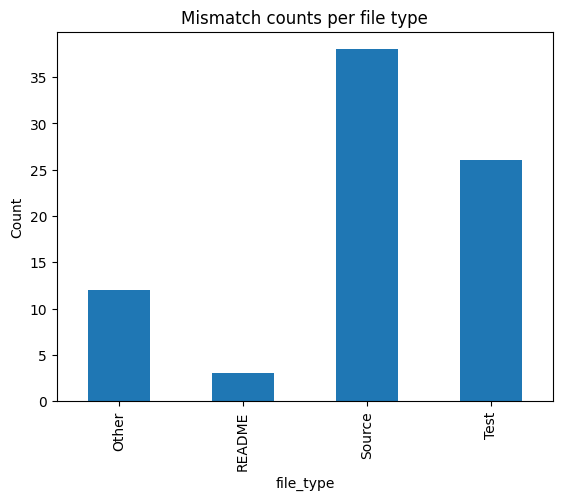

In [14]:
# ------------ STATISTICS ------------
print("📊 Calculating statistics...")

def classify_file(path):
    if path is None:
        return "Other"
    path = path.lower()
    if "test" in path:
        return "Test"
    if "readme" in path:
        return "README"
    if "license" in path:
        return "LICENSE"
    if path.endswith((".py", ".java", ".cpp", ".c", ".js", ".ts")):
        return "Source"
    return "Other"

df["file_type"] = df["new_file"].apply(classify_file)
mismatches = df[df["Discrepancy"] == "Yes"].groupby("file_type").size()

print(f"🔍 Found {len(df[df['Discrepancy'] == 'Yes'])} discrepancies out of {len(df)} total records")
print("\nMismatch Statistics by File Type:")
print(mismatches)

# ------------ PLOTTING ------------
print("\n📊 Generating visualization...")
mismatches.plot(kind="bar", title="Mismatch counts per file type")
plt.ylabel("Count")
plt.savefig("mismatch_stats.png")
print("📈 Chart saved as 'mismatch_stats.png'")
plt.show()
